In [7]:
import os
import sys
import pdb
import copy
import importlib
import numpy as np
import xarray as xr
import cmasher as cmr
from time import sleep
import matplotlib as mpl
from matplotlib import rc
from datetime import datetime
from matplotlib import gridspec
import matplotlib.pyplot as plt
from cftime import DatetimeNoLeap as date
from matplotlib.dates import DateFormatter

plt.rcParams.update({
    'font.size'       : 14,   # Base font size
    'axes.labelsize'  : 14,   # Axis labels
    'xtick.labelsize' : 13,   # X-axis tick labels
    'ytick.labelsize' : 13,   # Y-axis tick labels
    'legend.fontsize' : 12,   # Legend font size
    'figure.titlesize': 16    # Figure title size
})
#rc('font',**{'family':'serif','serif':['Palatino']})
#rc('text', usetex=True)
#mpl.rc('text', usetex = True)
#mpl.rc('font', family = 'serif')

plt.ioff()

sys.path.insert(1, '/global/homes/j/jhollo/repos/climate_analysis/CLDERA/TEM/limvar_analysis_NERSC')
import plotting_utils as putil
import compute_ensemble_stats as ces
importlib.reload(putil)
importlib.reload(ces)

<module 'compute_ensemble_stats' from '/global/homes/j/jhollo/repos/climate_analysis/CLDERA/TEM/limvar_analysis_NERSC/compute_ensemble_stats.py'>

In [10]:
importlib.reload(putil)
importlib.reload(ces)

# ---- settings
freq = 'monthly'
mass = 10
pmin, pmax = 0.2, 500
d2y  = 1/365 # days to years
d2mpd = (24*60*60) # days/s to day/day

#tmin, tmax, name = date(1992,2,1), date(1992,3,1), 'winter' # for winter 1994
tmin, tmax, name = date(1991,7,1), date(1991,8,1), 'summer' # for summer 1994

# --- read data
vargs = {'skip_nosrctag':True, 'freq':freq, 'pmin':pmin, 'pmax':pmax,
         'tmin':tmin, 'tmax':tmax, 'average_time':True, 'average_pres':False}
tropargs = {'skip_nosrctag':True, 'freq':freq,
            'tmin':tmin, 'tmax':tmax, 'average_time':True}
# -- AOA, tropopause
psitem = putil.get_variable('psitem', **vargs, mass=mass)
aoa    = putil.get_variable('AOA', **vargs, mass=mass)
trop   = putil.get_variable('TROP_P', **tropargs, mass=mass)
etfy   = putil.get_variable('etfy', **vargs, mass=mass, q='aoa')
etfz   = putil.get_variable('etfz', **vargs, mass=mass, q='aoa')
etdiv  = putil.get_variable('etdiv', **vargs, mass=mass, q='aoa')
psitem_glat = putil.get_variable('psitem_gradlat', **vargs, mass=mass)
psitem_gp   = putil.get_variable('psitem_gradp', **vargs, mass=mass)
# -- tendencies
aoatend     = putil.get_variable('AOATEND', **vargs, mass=mass)
dqdt        = putil.get_variable('qtendtotal', **vargs, mass=mass, q='aoa')
dqdt_snk    = putil.get_variable('qtendsink', **vargs, mass=mass, q='aoa')
dqdt_src    = putil.get_variable('qtendsource', **vargs, mass=mass, q='aoa')
dqdt_etfd   = putil.get_variable('qtendetfd', **vargs, mass=mass, q='aoa')
dqdt_resvel = putil.get_variable('qtendresvel', **vargs, mass=mass, q='aoa')
dqdt_diff   = putil.get_variable('qtenddiff', **vargs, mass=mass, q='aoa')

# ---- process data
for ds in ['cfmean', 'ensmean', 'impact']:
    aoa[ds]         *= d2y
    aoatend[ds]     *= d2mpd 
    dqdt[ds]         = (dqdt[ds] + dqdt_diff[ds]) * d2mpd 
    dqdt_snk[ds]    *= d2mpd 
    dqdt_src[ds]    *= d2mpd 
    dqdt_etfd[ds]   *= d2mpd 
    dqdt_resvel[ds] *= d2mpd 
    dqdt_diff[ds]   *= d2mpd 
    trop[ds]        /= 100
    psitem[ds]      /= 1e7

# ---- get dims
#time = [datetime(t.year, t.month, t.day) for t in aoa['cfmean'].time.values]
plev = aoa['cfmean'].plev
lat  = aoa['cfmean'].lat

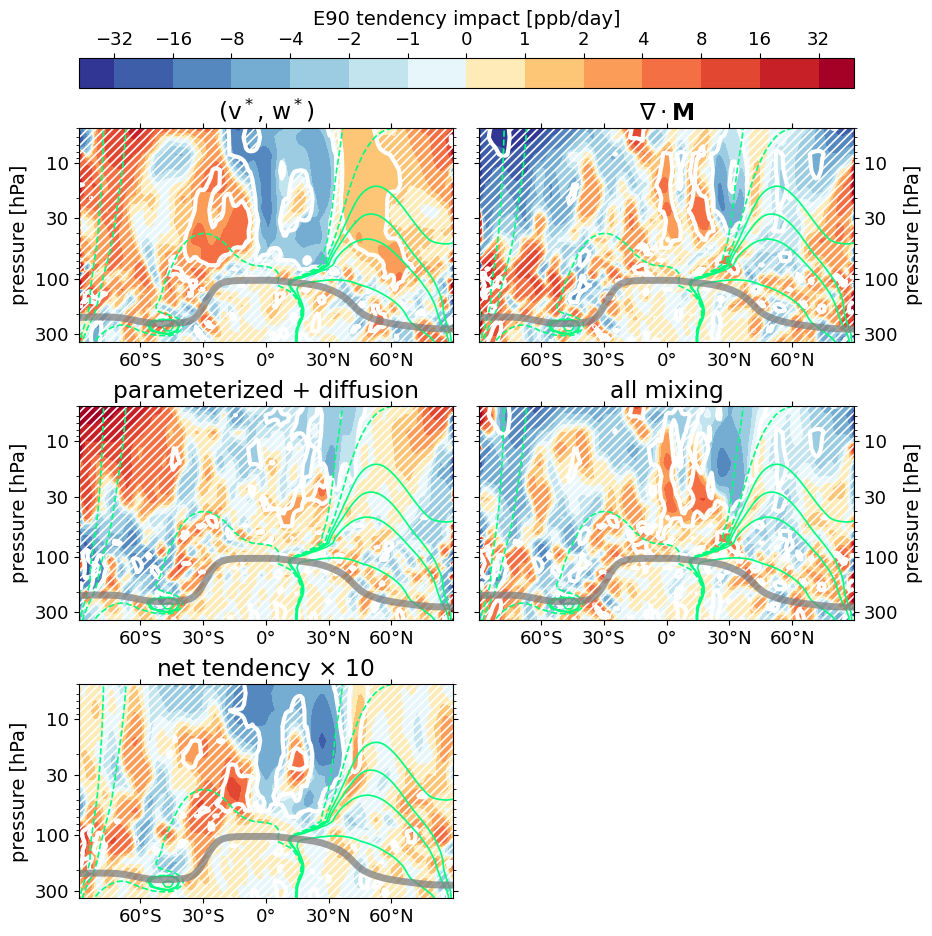

In [11]:
# ---- plotting settings
levels = np.array([-32, -16, -8, -4, -2, -1, 0, 1,  2,  4,  8, 16, 32])
ilevels = np.array([-32, -16, -8, -4, -2, -1, 0, 1,  2,  4,  8, 16, 32])
norm  = putil.get_cmap_norm(levels, 'uneven')
cmap  = putil.give_cmap_white_center('RdYlBu_r', center_width=0.11)
latticks = [-60, -30, 0, 30, 60]
pticks=[900, 500, 200, 100, 50]
tropp, tcol, tlw, talph = trop['cfmean'], 'grey', 5, 0.75
psitem_lev = np.array([10, 30, 300])
psitem_lev = list(-psitem_lev[::-1]) + [0] + list(psitem_lev)
rvcolor, rvlw = 'springgreen', 1.2

cfcol, cflw = 'k', 1.2
pcrit = 0.05
ihatch, isiglw, isigcolor='////', 3, 'w'
ihatchlw, ihatchcolor = 1.2, 'w'
mpl.rcParams['hatch.linewidth'] = ihatchlw
mpl.rcParams['hatch.color']     = ihatchcolor

if((tmax-tmin).days > 360): tend_fac = 100
else: tend_fac = 10
impact_fac = 10

fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(321)
ax2 = fig.add_subplot(322)
ax3 = fig.add_subplot(323)
ax4 = fig.add_subplot(324)
ax5 = fig.add_subplot(325)

PLOT_CF = False

# ---- pael(a) residual circulation advcection
cf     = dqdt_resvel['cfmean'].T
impact = dqdt_resvel['impact'].T * impact_fac
pval   = dqdt_resvel['pval'].T
ax1.contourf(lat, plev, impact, levels=ilevels, norm=norm, cmap=cmap, extend='both')
if(PLOT_CF): ax1.contour(lat, plev, cf, levels=levels, colors=cfcol, linewidths=cflw)
ax1.contourf(lat, plev, pval, levels=[pcrit, pval.max()], hatches=[ihatch], colors='w',alpha=0)
ax1.contour(lat, plev, pval, colors=isigcolor, levels=[pcrit], linewidths=isiglw)
ax1.set_title('(v$^*$, w$^*$)')

# --- panel(b) ETFD
cf     = dqdt_etfd['cfmean'].T
impact = dqdt_etfd['impact'].T * impact_fac
pval   = dqdt_etfd['pval'].T
ax2.contourf(lat, plev, impact, levels=ilevels, norm=norm, cmap=cmap, extend='both')
if(PLOT_CF): ax2.contour(lat, plev, cf, levels=levels, colors=cfcol, linewidths=cflw)
ax2.contourf(lat, plev, pval, levels=[pcrit, pval.max()], hatches=[ihatch], colors='w',alpha=0)
ax2.contour(lat, plev, pval, colors=isigcolor, levels=[pcrit], linewidths=isiglw)
ax2.set_title('$\\nabla\\cdot\\mathbf{M}$')

# ---- panel (c) parameterized
cf     = dqdt_diff['cfmean'].T
impact = dqdt_diff['impact'].T * impact_fac
pval   = dqdt_diff['pval'].T
ax3.contourf(lat, plev, impact, levels=ilevels, norm=norm, cmap=cmap, extend='both')
if(PLOT_CF): ax3.contour(lat, plev, cf, levels=levels, colors=cfcol, linewidths=cflw)
ax3.contourf(lat, plev, pval, levels=[pcrit, pval.max()], hatches=[ihatch], colors='w',alpha=0)
ax3.contour(lat, plev, pval, colors=isigcolor, levels=[pcrit], linewidths=isiglw)
ax3.set_title('parameterized + diffusion')

# ---- (d) source, sink
cf     = dqdt_etfd['cfmean'].T + dqdt_diff['cfmean'].T
impact = (dqdt_etfd['impact'].T + dqdt_diff['impact'].T) * impact_fac
pval   = xr.concat([dqdt_etfd['pval'].T, dqdt_diff['pval'].T], dim='tmp').min(dim='tmp')
ax4.contourf(lat, plev, impact, levels=ilevels, norm=norm, cmap=cmap, extend='both')
if(PLOT_CF): ax4.contour(lat, plev, cf, levels=levels, colors=cfcol, linewidths=cflw)
ax4.contourf(lat, plev, pval, levels=[pcrit, pval.max()], hatches=[ihatch], colors='w',alpha=0)
ax4.contour(lat, plev, pval, colors=isigcolor, levels=[pcrit], linewidths=isiglw)
ax4.set_title('all mixing')

# ---- (e) net tendency
cf     = dqdt['cfmean'].T * tend_fac
impact = dqdt['impact'].T * impact_fac
pval   = dqdt['pval'].T
gcf = ax5.contourf(lat, plev, impact, levels=ilevels, norm=norm, cmap=cmap, extend='both')
if(PLOT_CF): ax5.contour(lat, plev, cf, levels=levels, colors=cfcol, linewidths=cflw)
ax5.contourf(lat, plev, pval, levels=[pcrit, pval.max()], hatches=[ihatch], colors='w',alpha=0)
ax5.contour(lat, plev, pval, colors=isigcolor, levels=[pcrit], linewidths=isiglw)
ax5.set_title('net tendency $\\times$ {}'.format(tend_fac))

# ---- colorbar
#cb = plt.colorbar(gcf, cax=fig.add_axes([0.93, 0.15, 0.02, 0.7]), extendrect=True, orientation='horizontal')
cb = plt.colorbar(gcf, cax=fig.add_axes([0.125, 0.92, 0.775, 0.03]), extendrect=True, orientation='horizontal', location='top')
cb.set_label('E90 tendency impact [ppb/day]')
cb.ax.xaxis.set_ticks(ilevels[ilevels%0.5==0])

for ax in [ax1, ax2, ax3, ax4, ax5]:
    ax.contour(lat, plev, psitem['cfmean'].T, levels=psitem_lev, colors=rvcolor, linewidths=rvlw)
    ax.plot(lat, tropp, color=tcol, lw=tlw, alpha=talph)
    ax.set_ylabel('pressure [hPa]', fontsize=14)
    if(ax in [ax2, ax4]): yy =  'right'
    else:                 yy = 'left'
    putil.format_ticks(ax, y=yy)
    putil.format_paxis(ax)#, ticks=pticks)
    putil.format_lataxis(ax, ticks=latticks)
    ax.set_ylim([350, 5])

# ======================================================================================
    
PLOT_MVEC = False
if(PLOT_MVEC):
    # ----- plot scaled impact EP flux vectors, and delete insignificant, and plot
    interp_vectors=True
    etdslat, etdsp = 6,6
    log_etfd_vectors=False
    vw,vhw,vhl,vlw  = 0.004,4,3.5,0   # vector arrow width, head width, and head length, outline width to quiver()
    etvscale = 1e6
    #etvscale=25
    etvcolor = 'k'
    vecolor = 'w'

    # first interpolate the vector field to a uniform grid in lat-log(p)
    if(interp_vectors):
        etfyi, etfzi = putil.regrid_vectors_latp(etfy['cfmean'], etfz['cfmean'])
    else:
        etfyi, etfzi = etfy['cfmean'], etfz['cfmean']
    # do ET flux vector scaling
    # This MUST be done last so that the vector scaling is not corrupted by later 
    # modifications to the figure or axes size or data limits
    Fx, Fy = putil.scale_EP_flux_vectors(fig, ax2, etfyi, etfzi, dslat=etfdslat, dsp=etdsp, 
                                         dsplog=False, interp_lat=False, interp_plev=False, 
                                         log_vectors=log_etfd_vectors)
    # plot filtered, scaled vector field
    LAT, PLEV = np.meshgrid(Fx.lat, Fx.plev)
    qvep = ax2.quiver(LAT, PLEV, -Fx.T, -Fy.T, width=vw, headwidth=vhw, headlength=vhl, headaxislength=vhl*0.9, 
               scale=etvscale, scale_units='inches', color=etvcolor, zorder=20, edgecolor=vecolor, linewidth=vlw)
    qvep.set_rasterized(True)

PLOT_RVVEC = False
if(PLOT_RVVEC):
    # ----- plot residual velocity vectors
    interp_vectors=True
    rvdslat, rvdsp = 8,6
    log_resvel_vectors=True
    #rvvscale = 1e13
    rvvscale=50
    rvvcolor = 'k'

    # first interpolate the vector field to a uniform grid in lat-log(p)
    if(interp_vectors):
        glati, gpi = putil.regrid_vectors_latp(psitem_glat['cfmean'], psitem_gp['cfmean'])
    else:
        glati, gpi = psitem_glat['impact'], psitem_gp['impact']
    # finally get gradient-normal field from streamfunction
    gnx, gny = putil.streamfunction_gradient_normal(fig, ax1, dfdlat=glati, dfdp=gpi, dslat=rvdslat, dsp=rvdsp, 
                                                    dsplog=False, interp_lat=False, interp_plev=False, 
                                                    log_vectors=log_resvel_vectors)
    # plot filtered, scaled vector field
    LAT, PLEV = np.meshgrid(gnx.lat, gnx.plev)
    qvrv = ax1.quiver(LAT, PLEV, gnx.T, gny.T, scale=rvvscale, width=vw, headwidth=vhw, headlength=vhl, headaxislength=vhl*0.9, 
                      color=rvvcolor, zorder=20, edgecolor=vecolor, linewidth=vlw)
    qvrv.set_rasterized(True)

plt.subplots_adjust(hspace=0.3, wspace=0.07)
plt.savefig('figs/aoa_impact_budget_{}.pdf'.format(name), dpi=250, bbox_inches='tight')
plt.show()